## Лабораторная 4
Датасет: Набор данных для анализа и прогнозирования сердечного приступа

In [54]:
import pandas as pd
from sklearn import set_config

set_config(transform_output="pandas")
df = pd.read_csv("csv\\heart_2022_no_nans.csv")
print(df.columns)
map_heart_disease_to_int = {'No': 0, 'Yes': 1}

TARGET_COLUMN_NAME_CLASSIFICATION = 'HadHeartAttack'

df[TARGET_COLUMN_NAME_CLASSIFICATION] = df[TARGET_COLUMN_NAME_CLASSIFICATION].map(map_heart_disease_to_int).astype('int32')

Index(['State', 'Sex', 'GeneralHealth', 'PhysicalHealthDays',
       'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities',
       'SleepHours', 'RemovedTeeth', 'HadHeartAttack', 'HadAngina',
       'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory',
       'HeightInMeters', 'WeightInKilograms', 'BMI', 'AlcoholDrinkers',
       'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap',
       'HighRiskLastYear', 'CovidPos'],
      dtype='object')


## Классификация

### Бизнес цель 1: 
Предсказание сердечного приступа (HadHeartAttack) на основе других факторов.

Формируем выборки

In [55]:
from typing import Tuple
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import train_test_split

def split_stratified_into_train_val_test(
    df_input,
    stratify_colname="y",
    frac_train=0.6,
    frac_val=0.15,
    frac_test=0.25,
    random_state=None,
) -> Tuple[DataFrame, DataFrame, DataFrame, DataFrame, DataFrame, DataFrame]:
   
    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError(
            "fractions %f, %f, %f do not add up to 1.0"
            % (frac_train, frac_val, frac_test)
        )
    if stratify_colname not in df_input.columns:
        raise ValueError("%s is not a column in the dataframe" % (stratify_colname))
    X = df_input  # Contains all columns.
    y = df_input[
        [stratify_colname]
    ]  # Dataframe of just the column on which to stratify.
    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(
        X, y, stratify=y, test_size=(1.0 - frac_train), random_state=random_state
    )
    if frac_val <= 0:
        assert len(df_input) == len(df_train) + len(df_temp)
        return df_train, pd.DataFrame(), df_temp, y_train, pd.DataFrame(), y_temp
    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(
        df_temp,
        y_temp,
        stratify=y_temp,
        test_size=relative_frac_test,
        random_state=random_state,
    )
    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)
    return df_train, df_val, df_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_stratified_into_train_val_test(
    df, stratify_colname=TARGET_COLUMN_NAME_CLASSIFICATION, frac_train=0.80, frac_val=0, frac_test=0.20, random_state=9
)

display("X_train", X_train)
display("y_train", y_train)

display("X_test", X_test)
display("y_test", y_test)

'X_train'

State     Sex GeneralHealth  PhysicalHealthDays  \
6432          Arizona    Male     Very good                 0.0   
61767         Indiana  Female     Very good                 0.0   
102005       Michigan    Male     Very good                 0.0   
183791   South Dakota  Female          Good                10.0   
230656  West Virginia  Female          Good                 0.0   
...               ...     ...           ...                 ...   
93877        Maryland  Female     Very good                 0.0   
117856       Missouri    Male          Good                 0.0   
41922         Georgia    Male     Very good                 0.0   
98221   Massachusetts  Female          Good                 5.0   
151717       New York    Male     Very good                 2.0   

        MentalHealthDays                                    LastCheckupTime  \
6432                 5.0  Within past 5 years (2 years but less than 5 y...   
61767                0.0  Within past year (anytime less than 12 months ...   
102005               0.0  Within past year (anytime less than 12 months ...   
183791               5.0  Within past year (anytime less than 12 months ...   
230656               0.0  Within past year (anytime less than 12 months ...   
...                  ...                                                ...   
93877               12.0  Within past year (anytime less than 12 months ...   
117856               0.0  Within past year (anytime less than 12 months ...   
41922                0.0  Within past year (anytime less than 12 months ...   
98221               20.0  Within past 2 years (1 year but less than 2 ye...   
151717               0.0  Within past year (anytime less than 12 months ...   

       PhysicalActivities  SleepHours            RemovedTeeth  HadHeartAttack  \
6432                  Yes         8.0            None of them               0   
61767                 Yes         6.0            None of them               0   
102005                Yes         7.0            None of them               0   
183791                Yes         7.0            None of them               0   
230656                 No         8.0  6 or more, but not all               0   
...                   ...         ...                     ...             ...   
93877                  No         6.0  6 or more, but not all               0   
117856                Yes         8.0                  1 to 5               0   
41922                 Yes         7.0            None of them               0   
98221                  No         5.0            None of them               0   
151717                Yes         7.0            None of them               0   

        ... HeightInMeters WeightInKilograms    BMI AlcoholDrinkers  \
6432    ...           1.88             77.11  21.83             Yes   
61767   ...           1.73             77.11  25.85             Yes   
102005  ...           1.85             83.46  24.28             Yes   
183791  ...           1.75             81.65  26.58              No   
230656  ...           1.55             68.04  28.34              No   
...     ...            ...               ...    ...             ...   
93877   ...           1.65            113.40  41.60              No   
117856  ...           1.80            117.93  36.26              No   
41922   ...           1.78            113.40  35.87             Yes   
98221   ...           1.70             90.72  31.32             Yes   
151717  ...           1.73             68.95  23.11             Yes   

       HIVTesting FluVaxLast12 PneumoVaxEver  \
6432          Yes          Yes            No   
61767         Yes           No            No   
102005         No           No            No   
183791        Yes           No            No   
230656         No           No            No   
...           ...          ...           ...   
93877          No           No            No   
117856         No           No            No   
4192

'y_train'

HadHeartAttack
6432                 0
61767                0
102005               0
183791               0
230656               0
...                ...
93877                0
117856               0
41922                0
98221                0
151717               0

[196817 rows x 1 columns]

'X_test'

State     Sex GeneralHealth  PhysicalHealthDays  \
108080     Minnesota  Female     Very good                 0.0   
109629     Minnesota  Female     Very good                 1.0   
24640    Connecticut    Male          Good                15.0   
12715       Arkansas  Female          Good                 8.0   
162549          Ohio  Female     Excellent                 0.0   
...              ...     ...           ...                 ...   
187130  South Dakota    Male          Poor                30.0   
38512        Florida    Male     Excellent                 0.0   
125776      Nebraska    Male          Fair                 1.0   
33614        Florida  Female          Good                 0.0   
223067    Washington    Male     Excellent                 0.0   

        MentalHealthDays                                    LastCheckupTime  \
108080               0.0  Within past year (anytime less than 12 months ...   
109629              15.0  Within past year (anytime less than 12 months ...   
24640                5.0  Within past year (anytime less than 12 months ...   
12715               30.0  Within past year (anytime less than 12 months ...   
162549               7.0  Within past year (anytime less than 12 months ...   
...                  ...                                                ...   
187130              30.0  Within past year (anytime less than 12 months ...   
38512                0.0  Within past 5 years (2 years but less than 5 y...   
125776               2.0  Within past year (anytime less than 12 months ...   
33614                0.0  Within past year (anytime less than 12 months ...   
223067               2.0  Within past 2 years (1 year but less than 2 ye...   

       PhysicalActivities  SleepHours            RemovedTeeth  HadHeartAttack  \
108080                Yes         7.0            None of them               0   
109629                Yes         6.0            None of them               0   
24640                 Yes         7.0  6 or more, but not all               0   
12715                 Yes         7.0                  1 to 5               0   
162549                Yes         4.0            None of them               0   
...                   ...         ...                     ...             ...   
187130                 No         4.0            None of them               0   
38512                 Yes         8.0            None of them               0   
125776                 No         6.0                  1 to 5               0   
33614                 Yes         7.0            None of them               0   
223067                Yes         7.0                  1 to 5               0   

        ... HeightInMeters WeightInKilograms    BMI AlcoholDrinkers  \
108080  ...           1.68             81.65  29.05             Yes   
109629  ...           1.68             99.79  35.51             Yes   
24640   ...           1.70             72.57  25.06             Yes   
12715   ...           1.63             86.18  32.61             Yes   
162549  ...           1.60             81.19  31.71             Yes   
...     ...            ...               ...    ...             ...   
187130  ...           1.83             97.98  29.29             Yes   
38512   ...           1.83            104.33  31.19             Yes   
125776  ...           1.73             92.99  31.17              No   
33614   ...           1.60             65.77  25.69             Yes   
223067  ...           1.75             70.00  22.86             Yes   

       HIVTesting FluVaxLast12 PneumoVaxEver  \
108080         No           No            No   
109629         No          Yes            No   
24640         Yes          Yes           Yes   
12715         Yes          Yes            No   
162549        Yes          Yes            No   
...           ...          ...           ...   
187130         No           No            No   
38512          No           No            No   
125776        Y

'y_test'

HadHeartAttack
108080               0
109629               0
24640                0
12715                0
162549               0
...                ...
187130               0
38512                0
125776               0
33614                0
223067               0

[49205 rows x 1 columns]

In [56]:
null_values = df.isnull().sum()
print("Пропущенные значения по столбцам:")
print(null_values)

stat_summary = df.describe()
print("\nСтатистический обзор данных:")
print(stat_summary)

Пропущенные значения по столбцам:
State                        0
Sex                          0
GeneralHealth                0
PhysicalHealthDays           0
MentalHealthDays             0
LastCheckupTime              0
PhysicalActivities           0
SleepHours                   0
RemovedTeeth                 0
HadHeartAttack               0
HadAngina                    0
HadStroke                    0
HadAsthma                    0
HadSkinCancer                0
HadCOPD                      0
HadDepressiveDisorder        0
HadKidneyDisease             0
HadArthritis                 0
HadDiabetes                  0
DeafOrHardOfHearing          0
BlindOrVisionDifficulty      0
DifficultyConcentrating      0
DifficultyWalking            0
DifficultyDressingBathing    0
DifficultyErrands            0
SmokerStatus                 0
ECigaretteUsage              0
ChestScan                    0
RaceEthnicityCategory        0
AgeCategory                  0
HeightInMeters               0
Weigh

Формируем конвеер для классификации данных и проверка конвеера

In [57]:
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

columns_to_drop = ['AgeCategory', 'Sex']
num_columns = [
    column
    for column in df.columns
    if column not in columns_to_drop and df[column].dtype != "object"
]
cat_columns = [
    column
    for column in df.columns
    if column not in columns_to_drop and df[column].dtype == "object"
]

num_imputer = SimpleImputer(strategy="median")
num_scaler = StandardScaler()
preprocessing_num = Pipeline(
    [
        ("imputer", num_imputer),
        ("scaler", num_scaler),
    ]
)

cat_imputer = SimpleImputer(strategy="constant", fill_value="unknown")
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
preprocessing_cat = Pipeline(
    [
        ("imputer", cat_imputer),
        ("encoder", cat_encoder),
    ]
)

features_preprocessing = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("prepocessing_num", preprocessing_num, num_columns),
        ("prepocessing_cat", preprocessing_cat, cat_columns),
    ],
    remainder="passthrough"
)

drop_columns = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("drop_columns", "drop", columns_to_drop),
    ],
    remainder="passthrough",
)


pipeline_end = Pipeline(
    [
        ("features_preprocessing", features_preprocessing),
        ("drop_columns", drop_columns),
    ]
)

preprocessing_result = pipeline_end.fit_transform(X_train)
preprocessed_df = pd.DataFrame(
    preprocessing_result,
    columns=pipeline_end.get_feature_names_out(),
)

preprocessed_df

PhysicalHealthDays  MentalHealthDays  SleepHours  HadHeartAttack  \
6432             -0.490179          0.103124    0.677965        -0.24034   
61767            -0.490179         -0.513985   -0.708460        -0.24034   
102005           -0.490179         -0.513985   -0.015247        -0.24034   
183791            0.699048          0.103124   -0.015247        -0.24034   
230656           -0.490179         -0.513985    0.677965        -0.24034   
...                    ...               ...         ...             ...   
93877            -0.490179          0.967076   -0.708460        -0.24034   
117856           -0.490179         -0.513985    0.677965        -0.24034   
41922            -0.490179         -0.513985   -0.015247        -0.24034   
98221             0.104435          1.954450   -1.401672        -0.24034   
151717           -0.252334         -0.513985   -0.015247        -0.24034   

        HeightInMeters  WeightInKilograms       BMI  State_Alaska  \
6432          1.639362          -0.304540 -1.051314           0.0   
61767         0.233664          -0.304540 -0.432966           0.0   
102005        1.358222          -0.006656 -0.674460           0.0   
183791        0.421091          -0.091564 -0.320678           0.0   
230656       -1.453173          -0.730021 -0.049959           0.0   
...                ...                ...       ...           ...   
93877        -0.516041           1.397856  1.989666           0.0   
117856        0.889656           1.610362  1.168279           0.0   
41922         0.702230           1.397856  1.108290           0.0   
98221        -0.047475           0.333917  0.408418           0.0   
151717        0.233664          -0.687332 -0.854427           0.0   

        State_Arizona  State_Arkansas  ...  AlcoholDrinkers_Yes  \
6432              1.0             0.0  ...                  1.0   
61767             0.0             0.0  ...                  1.0   
102005            0.0             0.0  ...                  1.0   
183791            0.0             0.0  ...                  0.0   
230656            0.0             0.0  ...                  0.0   
...               ...             ...  ...                  ...   
93877             0.0             0.0  ...                  0.0   
117856            0.0             0.0  ...                  0.0   
41922             0.0             0.0  ...                  1.0   
98221             0.0             0.0  ...                  1.0   
151717            0.0             0.0  ...                  1.0   

        HIVTesting_Yes  FluVaxLast12_Yes  PneumoVaxEver_Yes  \
6432               1.0               1.0                0.0   
61767              1.0               0.0                0.0   
102005             0.0               0.0                0.0   
183791             1.0               0.0                0.0   
230656             0.0               0.0                0.0   
...                ...               ...                ...   
93877              0.0               0.0                0.0   
117856             0.0               0.0                0.0   
41922              0.0               1.0                0.0   
98221              1.0               0.0                1.0   
151717             1.0               1.0                0.0   

        TetanusLast10Tdap_Yes, received Tdap  \
6432                                     0.0   
61767                                    1.0   
102005                                   1.0   
183791                                   0.0   
230656                                   0.0   
...                                      ...   
93877                                    1.0   
117856                                   0.0   
41922                                    0.0   
98221                                    1.0   
151717                                   1.0   

        TetanusLast10Tdap_Yes, received tetanus shot but not sure what type  \
6432                                            

Формируем набор моделей

In [58]:
from sklearn import ensemble, linear_model, naive_bayes, neighbors, neural_network, tree


class_models = {
    "logistic": {"model": linear_model.LogisticRegression()},
    "ridge": {"model": linear_model.LogisticRegression(penalty="l2", class_weight="balanced")},
    "decision_tree": {
        "model": tree.DecisionTreeClassifier(max_depth=7, random_state=9)
    },
    "knn": {"model": neighbors.KNeighborsClassifier(n_neighbors=7)},
    "naive_bayes": {"model": naive_bayes.GaussianNB()},
    "gradient_boosting": {
        "model": ensemble.GradientBoostingClassifier(n_estimators=210)
    },
    "random_forest": {
        "model": ensemble.RandomForestClassifier(
            max_depth=11, class_weight="balanced", random_state=9
        )
    },
    "mlp": {
        "model": neural_network.MLPClassifier(
            hidden_layer_sizes=(7,),
            max_iter=500,
            early_stopping=True,
            random_state=9,
        )
    },
}

Обучаем модели и тестируем их

In [59]:
import numpy as np
from sklearn import metrics

for model_name in class_models.keys():
    print(f"Model: {model_name}")
    model = class_models[model_name]["model"]

    model_pipeline = Pipeline([("pipeline", pipeline_end), ("model", model)])
    model_pipeline = model_pipeline.fit(X_train, y_train.values.ravel())

    y_train_predict = model_pipeline.predict(X_train)
    y_test_probs = model_pipeline.predict_proba(X_test)[:, 1]
    y_test_predict = np.where(y_test_probs > 0.5, 1, 0)

    class_models[model_name]["pipeline"] = model_pipeline
    class_models[model_name]["probs"] = y_test_probs
    class_models[model_name]["preds"] = y_test_predict

    class_models[model_name]["Precision_train"] = metrics.precision_score(
        y_train, y_train_predict
    )
    class_models[model_name]["Precision_test"] = metrics.precision_score(
        y_test, y_test_predict
    )
    class_models[model_name]["Recall_train"] = metrics.recall_score(
        y_train, y_train_predict
    )
    class_models[model_name]["Recall_test"] = metrics.recall_score(
        y_test, y_test_predict
    )
    class_models[model_name]["Accuracy_train"] = metrics.accuracy_score(
        y_train, y_train_predict
    )
    class_models[model_name]["Accuracy_test"] = metrics.accuracy_score(
        y_test, y_test_predict
    )
    class_models[model_name]["ROC_AUC_test"] = metrics.roc_auc_score(
        y_test, y_test_probs
    )
    class_models[model_name]["F1_train"] = metrics.f1_score(y_train, y_train_predict, average=None)
    class_models[model_name]["F1_test"] = metrics.f1_score(y_test, y_test_predict, average=None)
    class_models[model_name]["MCC_test"] = metrics.matthews_corrcoef(
        y_test, y_test_predict
    )
    class_models[model_name]["Cohen_kappa_test"] = metrics.cohen_kappa_score(
        y_test, y_test_predict
    )
    class_models[model_name]["Confusion_matrix"] = metrics.confusion_matrix(
        y_test, y_test_predict
    )

Model: logistic
Model: ridge
Model: decision_tree
Model: knn
Model: naive_bayes
Model: gradient_boosting
Model: random_forest
Model: mlp


Матрица неточностей

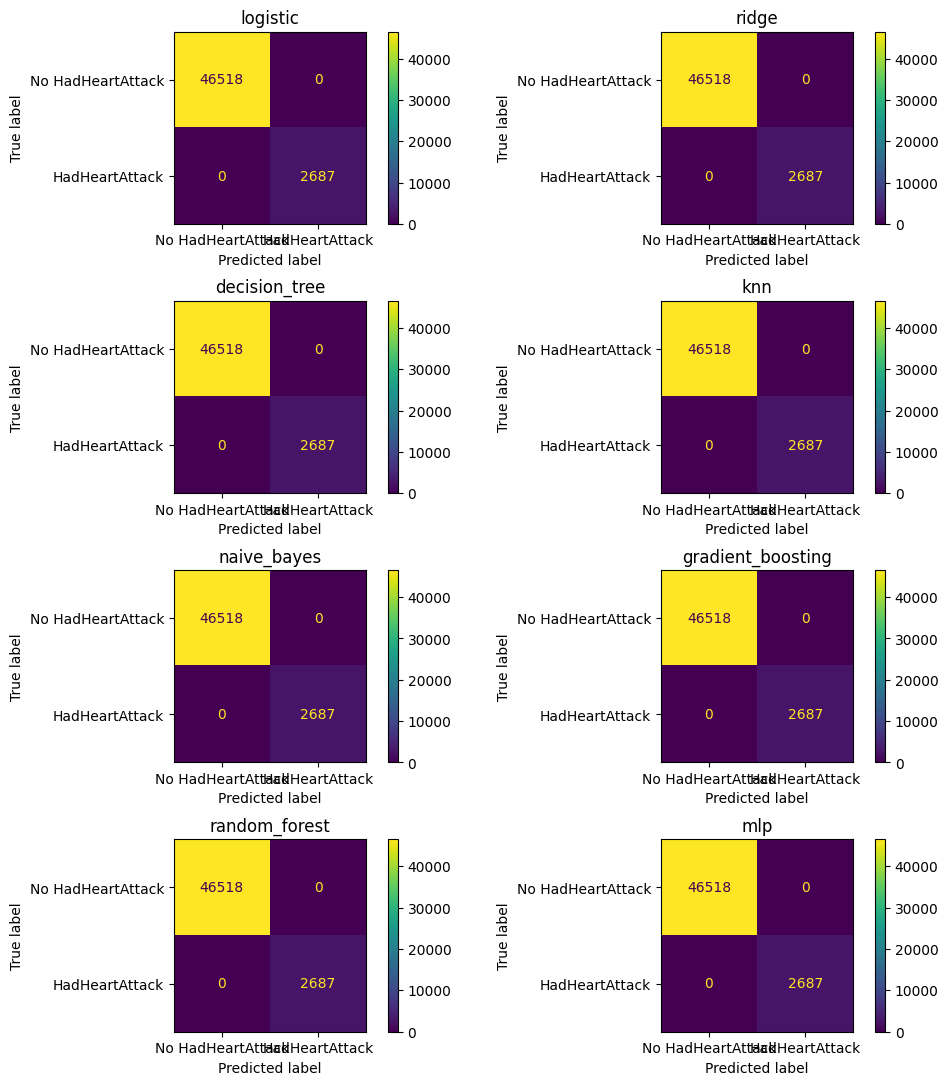

In [60]:
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

_, ax = plt.subplots(int(len(class_models) / 2), 2, figsize=(12, 10), sharex=False, sharey=False)
for index, key in enumerate(class_models.keys()):
    c_matrix = class_models[key]["Confusion_matrix"]
    disp = ConfusionMatrixDisplay(
        confusion_matrix=c_matrix, display_labels=[f"No {TARGET_COLUMN_NAME_CLASSIFICATION}", TARGET_COLUMN_NAME_CLASSIFICATION]
    ).plot(ax=ax.flat[index])
    disp.ax_.set_title(key)

plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.1)
plt.show()

Точность, полнота, верность (аккуратность), F-мера

In [61]:
class_metrics = pd.DataFrame.from_dict(class_models, "index")[
    [
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
        "Accuracy_train",
        "Accuracy_test",
        "F1_train",
        "F1_test",
    ]
]
class_metrics.sort_values(
    by="Accuracy_test", ascending=False
)

Precision_train  Precision_test  Recall_train  Recall_test  \
logistic                       1.0             1.0      1.000000          1.0   
ridge                          1.0             1.0      1.000000          1.0   
decision_tree                  1.0             1.0      1.000000          1.0   
knn                            1.0             1.0      0.999907          1.0   
naive_bayes                    1.0             1.0      1.000000          1.0   
gradient_boosting              1.0             1.0      1.000000          1.0   
random_forest                  1.0             1.0      1.000000          1.0   
mlp                            1.0             1.0      1.000000          1.0   

                   Accuracy_train  Accuracy_test  \
logistic                 1.000000            1.0   
ridge                    1.000000            1.0   
decision_tree            1.000000            1.0   
knn                      0.999995            1.0   
naive_bayes              1.000000            1.0   
gradient_boosting        1.000000            1.0   
random_forest            1.000000            1.0   
mlp                      1.000000            1.0   

                                                   F1_train     F1_test  
logistic                                         [1.0, 1.0]  [1.0, 1.0]  
ridge                                            [1.0, 1.0]  [1.0, 1.0]  
decision_tree                                    [1.0, 1.0]  [1.0, 1.0]  
knn                [0.9999973128320332, 0.9999534775529193]  [1.0, 1.0]  
naive_bayes                                      [1.0, 1.0]  [1.0, 1.0]  
gradient_boosting                                [1.0, 1.0]  [1.0, 1.0]  
random_forest                                    [1.0, 1.0]  [1.0, 1.0]  
mlp                                              [1.0, 1.0]  [1.0, 1.0]

ROC-кривая, каппа Коэна, коэффициент корреляции Мэтьюса

In [62]:
class_metrics = pd.DataFrame.from_dict(class_models, "index")[
    [
        "Accuracy_test",
        "F1_test",
        "ROC_AUC_test",
        "Cohen_kappa_test",
        "MCC_test",
    ]
]
class_metrics.sort_values(by="ROC_AUC_test", ascending=False)

Accuracy_test     F1_test  ROC_AUC_test  Cohen_kappa_test  \
logistic                     1.0  [1.0, 1.0]           1.0               1.0   
ridge                        1.0  [1.0, 1.0]           1.0               1.0   
decision_tree                1.0  [1.0, 1.0]           1.0               1.0   
knn                          1.0  [1.0, 1.0]           1.0               1.0   
naive_bayes                  1.0  [1.0, 1.0]           1.0               1.0   
gradient_boosting            1.0  [1.0, 1.0]           1.0               1.0   
random_forest                1.0  [1.0, 1.0]           1.0               1.0   
mlp                          1.0  [1.0, 1.0]           1.0               1.0   

                   MCC_test  
logistic                1.0  
ridge                   1.0  
decision_tree           1.0  
knn                     1.0  
naive_bayes             1.0  
gradient_boosting       1.0  
random_forest           1.0  
mlp                     1.0

Лучшая модель

In [63]:
best_model = str(class_metrics.sort_values(by="MCC_test", ascending=False).iloc[0].name)

display(best_model)

'logistic'

Находим ошибки

In [64]:
preprocessing_result = pipeline_end.transform(X_test)
preprocessed_df = pd.DataFrame(
    preprocessing_result,
    columns=pipeline_end.get_feature_names_out(),
)

y_new_pred = class_models[best_model]["preds"]

error_index = y_test[y_test[TARGET_COLUMN_NAME_CLASSIFICATION] != y_new_pred].index.tolist()
display(f"Error items count: {len(error_index)}")

error_predicted = pd.Series(y_new_pred, index=y_test.index).loc[error_index]
error_df = X_test.loc[error_index].copy()
error_df.insert(loc=1, column="Predicted", value=error_predicted)
error_df.sort_index()

'Error items count: 0'

Empty DataFrame
Columns: [State, Predicted, Sex, GeneralHealth, PhysicalHealthDays, MentalHealthDays, LastCheckupTime, PhysicalActivities, SleepHours, RemovedTeeth, HadHeartAttack, HadAngina, HadStroke, HadAsthma, HadSkinCancer, HadCOPD, HadDepressiveDisorder, HadKidneyDisease, HadArthritis, HadDiabetes, DeafOrHardOfHearing, BlindOrVisionDifficulty, DifficultyConcentrating, DifficultyWalking, DifficultyDressingBathing, DifficultyErrands, SmokerStatus, ECigaretteUsage, ChestScan, RaceEthnicityCategory, AgeCategory, HeightInMeters, WeightInKilograms, BMI, AlcoholDrinkers, HIVTesting, FluVaxLast12, PneumoVaxEver, TetanusLast10Tdap, HighRiskLastYear, CovidPos]
Index: []

[0 rows x 41 columns]

Пример использования модели (конвейера) для предсказания

In [65]:
model = class_models[best_model]["pipeline"]


example_id = 187130
test = pd.DataFrame(X_test.loc[example_id, :]).T
test_preprocessed = pd.DataFrame(preprocessed_df.loc[example_id, :]).T
display(test)
display(test_preprocessed)
result_proba = model.predict_proba(test)[0]
result = model.predict(test)[0]
real = int(y_test.loc[example_id].values[0])
display(f"predicted: {result} (proba: {result_proba})")
display(f"real: {real}")

State   Sex GeneralHealth PhysicalHealthDays MentalHealthDays  \
187130  South Dakota  Male          Poor               30.0             30.0   

                                          LastCheckupTime PhysicalActivities  \
187130  Within past year (anytime less than 12 months ...                 No   

       SleepHours  RemovedTeeth HadHeartAttack  ... HeightInMeters  \
187130        4.0  None of them              0  ...           1.83   

       WeightInKilograms    BMI AlcoholDrinkers HIVTesting FluVaxLast12  \
187130             97.98  29.29             Yes         No           No   

       PneumoVaxEver                                  TetanusLast10Tdap  \
187130            No  No, did not receive any tetanus shot in the pa...   

       HighRiskLastYear CovidPos  
187130               No       No  

[1 rows x 40 columns]

PhysicalHealthDays  MentalHealthDays  SleepHours  HadHeartAttack  \
187130            3.077503          3.188668   -2.094884        -0.24034   

        HeightInMeters  WeightInKilograms       BMI  State_Alaska  \
187130        1.170796            0.67449  0.096168           0.0   

        State_Arizona  State_Arkansas  ...  AlcoholDrinkers_Yes  \
187130            0.0             0.0  ...                  1.0   

        HIVTesting_Yes  FluVaxLast12_Yes  PneumoVaxEver_Yes  \
187130             0.0               0.0                0.0   

        TetanusLast10Tdap_Yes, received Tdap  \
187130                                   0.0   

        TetanusLast10Tdap_Yes, received tetanus shot but not sure what type  \
187130                                                0.0                     

        TetanusLast10Tdap_Yes, received tetanus shot, but not Tdap  \
187130                                                0.0            

        HighRiskLastYear_Yes  \
187130                   0.0   

        CovidPos_Tested positive using home test without a health professional  \
187130                                                0.0                        

        CovidPos_Yes  
187130           0.0  

[1 rows x 109 columns]

'predicted: 0 (proba: [9.99540301e-01 4.59698535e-04])'

'real: 0'

Создаем гиперпараметры методом поиска по сетке

In [66]:
from sklearn.model_selection import GridSearchCV


optimized_model_type = 'random_forest'
random_state = 9

random_forest_model = class_models[optimized_model_type]["pipeline"]

param_grid = {
    "model__n_estimators": [10, 50, 100],
    "model__max_features": ["sqrt", "log2"],
    "model__max_depth": [5, 7, 10],
    "model__criterion": ["gini", "entropy"],
}

gs_optomizer = GridSearchCV(
    estimator=random_forest_model, param_grid=param_grid, n_jobs=-1
)
gs_optomizer.fit(X_train, y_train.values.ravel())
gs_optomizer.best_params_


d:\code\AIM-PIbd-31-Potapov-N-S\lab_4\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'model__criterion': 'gini',
 'model__max_depth': 10,
 'model__max_features': 'sqrt',
 'model__n_estimators': 100}

Обучение модели с новыми гиперпараметрами

In [67]:
optimized_model = ensemble.RandomForestClassifier(
    random_state=42,
    criterion="gini",
    max_depth=5,
    max_features="sqrt",
    n_estimators=50,
)

result = {}

result["pipeline"] = Pipeline([("pipeline", pipeline_end), ("model", optimized_model)]).fit(X_train, y_train.values.ravel())
result["train_preds"] = result["pipeline"].predict(X_train)
result["probs"] = result["pipeline"].predict_proba(X_test)[:, 1]
result["preds"] = np.where(result["probs"] > 0.5, 1, 0)

result["Precision_train"] = metrics.precision_score(y_train, result["train_preds"])
result["Precision_test"] = metrics.precision_score(y_test, result["preds"])
result["Recall_train"] = metrics.recall_score(y_train, result["train_preds"])
result["Recall_test"] = metrics.recall_score(y_test, result["preds"])
result["Accuracy_train"] = metrics.accuracy_score(y_train, result["train_preds"])
result["Accuracy_test"] = metrics.accuracy_score(y_test, result["preds"])
result["ROC_AUC_test"] = metrics.roc_auc_score(y_test, result["probs"])
result["F1_train"] = metrics.f1_score(y_train, result["train_preds"])
result["F1_test"] = metrics.f1_score(y_test, result["preds"])
result["MCC_test"] = metrics.matthews_corrcoef(y_test, result["preds"])
result["Cohen_kappa_test"] = metrics.cohen_kappa_score(y_test, result["preds"])
result["Confusion_matrix"] = metrics.confusion_matrix(y_test, result["preds"])

Формирование данных для оценки старой и новой версии модели и сама оценка данных

In [68]:
optimized_metrics = pd.DataFrame(columns=list(result.keys()))
optimized_metrics.loc[len(optimized_metrics)] = pd.Series(
    data=class_models[optimized_model_type]
)
optimized_metrics.loc[len(optimized_metrics)] = pd.Series(
    data=result
)
optimized_metrics.insert(loc=0, column="Name", value=["Old", "New"])
optimized_metrics = optimized_metrics.set_index("Name")

optimized_metrics[
    [
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
        "Accuracy_train",
        "Accuracy_test",
        "F1_train",
        "F1_test",
    ]
]

Precision_train Precision_test Recall_train Recall_test Accuracy_train  \
Name                                                                          
Old              1.0            1.0          1.0         1.0            1.0   
New              1.0            1.0     0.304987    0.298846       0.962046   

     Accuracy_test    F1_train     F1_test  
Name                                        
Old            1.0  [1.0, 1.0]  [1.0, 1.0]  
New       0.961711    0.467418    0.460172

In [69]:
optimized_metrics[
    [
        "Accuracy_test",
        "F1_test",
        "ROC_AUC_test",
        "Cohen_kappa_test",
        "MCC_test",
    ]
]

Accuracy_test     F1_test ROC_AUC_test Cohen_kappa_test  MCC_test
Name                                                                  
Old            1.0  [1.0, 1.0]          1.0              1.0       1.0
New       0.961711    0.460172     0.999994         0.446257  0.535924

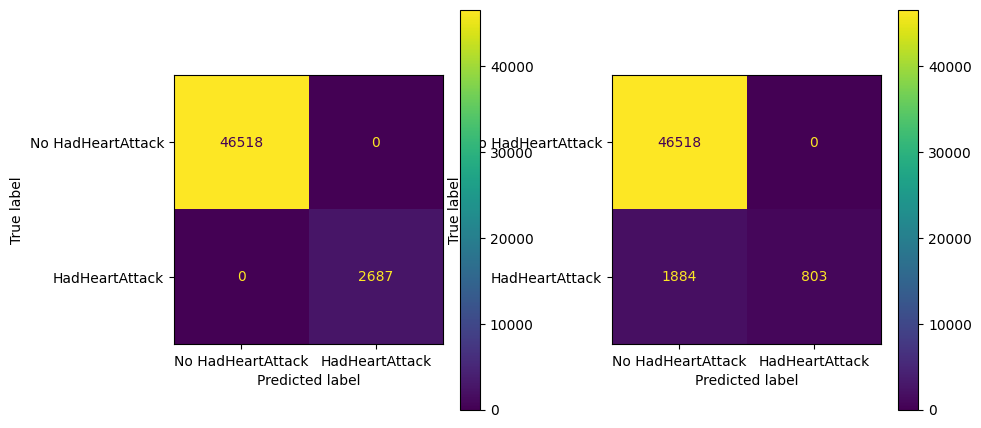

In [70]:
_, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=False
)

for index in range(0, len(optimized_metrics)):
    c_matrix = optimized_metrics.iloc[index]["Confusion_matrix"]
    disp = ConfusionMatrixDisplay(
        confusion_matrix=c_matrix, display_labels=[f"No {TARGET_COLUMN_NAME_CLASSIFICATION}", TARGET_COLUMN_NAME_CLASSIFICATION]
    ).plot(ax=ax.flat[index])

plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.3)
plt.show()

Модель хорошо классифицировала объекты, которые относятся к "No HadHeartAttack" и "HadHeartAttack"

## Регрессия

### Бизнес цель 2: 
Предсказание среднего количества часов сна в день (SleepTime) на основе других факторов.

Формируем выборки

In [85]:
df = pd.read_csv("csv\\heart_2022_no_nans.csv")

TARGET_COLUMN_NAME_REGRESSION = "SleepHours"

def split_into_train_test(
    df_input: DataFrame,
    target_colname: str,
    frac_train: float = 0.8,
    random_state: int = None,
) -> Tuple[DataFrame, DataFrame, DataFrame, DataFrame]:
    
    if not (0 < frac_train < 1):
        raise ValueError("Fraction must be between 0 and 1.")
    
    if target_colname not in df_input.columns:
        raise ValueError(f"{target_colname} is not a column in the DataFrame.")
    
    X = df_input.drop(columns=[target_colname])
    y = df_input[[target_colname]]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=(1.0 - frac_train),
        random_state=random_state
    )
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_into_train_test(
    df, 
    target_colname=TARGET_COLUMN_NAME_REGRESSION, 
    frac_train=0.8, 
    random_state=42
)

display("X_train", X_train)
display("y_train", y_train)

display("X_test", X_test)
display("y_test", y_test)

'X_train'

State     Sex GeneralHealth  PhysicalHealthDays  \
108769      Minnesota    Male          Good                 0.0   
240750           Guam    Male     Excellent                 0.0   
100329       Michigan  Female     Excellent                 3.0   
132628  New Hampshire    Male          Good                 4.0   
72101          Kansas    Male     Very good                 0.0   
...               ...     ...           ...                 ...   
119879       Missouri  Female     Excellent                 0.0   
103694       Michigan  Female          Good                10.0   
131932         Nevada  Female          Good                 0.0   
146867       New York  Female     Very good                 0.0   
121958        Montana  Female          Good                 1.0   

        MentalHealthDays                                    LastCheckupTime  \
108769               0.0  Within past year (anytime less than 12 months ...   
240750               0.0  Within past 2 years (1 year but less than 2 ye...   
100329               0.0  Within past year (anytime less than 12 months ...   
132628               6.0  Within past year (anytime less than 12 months ...   
72101                2.0  Within past year (anytime less than 12 months ...   
...                  ...                                                ...   
119879               0.0  Within past year (anytime less than 12 months ...   
103694               0.0  Within past year (anytime less than 12 months ...   
131932               0.0  Within past year (anytime less than 12 months ...   
146867               0.0  Within past year (anytime less than 12 months ...   
121958               0.0  Within past year (anytime less than 12 months ...   

       PhysicalActivities  RemovedTeeth HadHeartAttack HadAngina  ...  \
108769                Yes  None of them             No        No  ...   
240750                Yes  None of them             No       Yes  ...   
100329                 No        1 to 5             No       Yes  ...   
132628                Yes        1 to 5             No       Yes  ...   
72101                 Yes  None of them             No        No  ...   
...                   ...           ...            ...       ...  ...   
119879                Yes  None of them             No        No  ...   
103694                Yes        1 to 5             No        No  ...   
131932                Yes        1 to 5             No        No  ...   
146867                Yes        1 to 5             No        No  ...   
121958                Yes           All             No        No  ...   

       HeightInMeters WeightInKilograms    BMI AlcoholDrinkers HIVTesting  \
108769           1.73             83.91  28.13              No        Yes   
240750           1.65             70.31  25.79             Yes         No   
100329           1.60             58.97  23.03              No         No   
132628           1.70             68.04  23.49             Yes         No   
72101            1.83             99.79  29.84             Yes         No   
...               ...               ...    ...             ...        ...   
119879           1.78             61.23  19.37             Yes        Yes   
103694           1.63             74.84  28.32             Yes         No   
131932           1.70             90.72  31.32              No         No   
146867           1.68             77.11  27.44             Yes         No   
121958           1.65             98.88  36.28             Yes        Yes   

       FluVaxLast12 PneumoVaxEver  \
108769          Yes           Yes   
240750           No            No   
100329          Yes           Yes   
132628          Yes            No   
72101           Yes           Yes   
...             ...           ...   
119879          Yes            No   
103694          Yes           Yes   
131932           No            No   
146867          Yes            No   
121958          Yes           Yes   

               

'y_train'

SleepHours
108769         6.0
240750         7.0
100329         9.0
132628         6.0
72101          7.0
...            ...
119879         8.0
103694         8.0
131932         7.0
146867         8.0
121958         8.0

[196817 rows x 1 columns]

'X_test'

State     Sex GeneralHealth  PhysicalHealthDays  \
194767         Texas  Female          Good                 0.0   
231923     Wisconsin  Female          Good                 2.0   
52815          Idaho    Male          Poor                 7.0   
65909           Iowa  Female          Good                20.0   
184154  South Dakota  Female     Excellent                 0.0   
...              ...     ...           ...                 ...   
57503        Indiana  Female          Fair                 3.0   
47420         Hawaii  Female          Fair                30.0   
186088  South Dakota  Female          Good                15.0   
11687       Arkansas    Male     Excellent                 0.0   
200835          Utah    Male     Very good                 0.0   

        MentalHealthDays                                    LastCheckupTime  \
194767               0.0  Within past year (anytime less than 12 months ...   
231923               5.0  Within past year (anytime less than 12 months ...   
52815               10.0  Within past year (anytime less than 12 months ...   
65909               10.0  Within past year (anytime less than 12 months ...   
184154               0.0  Within past year (anytime less than 12 months ...   
...                  ...                                                ...   
57503                0.0  Within past year (anytime less than 12 months ...   
47420                5.0  Within past year (anytime less than 12 months ...   
186088              15.0  Within past year (anytime less than 12 months ...   
11687                0.0  Within past year (anytime less than 12 months ...   
200835               0.0  Within past year (anytime less than 12 months ...   

       PhysicalActivities  RemovedTeeth HadHeartAttack HadAngina  ...  \
194767                Yes  None of them             No        No  ...   
231923                Yes        1 to 5             No        No  ...   
52815                 Yes        1 to 5             No       Yes  ...   
65909                  No           All            Yes        No  ...   
184154                Yes  None of them             No        No  ...   
...                   ...           ...            ...       ...  ...   
57503                 Yes        1 to 5            Yes        No  ...   
47420                 Yes  None of them             No        No  ...   
186088                Yes        1 to 5             No        No  ...   
11687                 Yes  None of them             No        No  ...   
200835                Yes  None of them             No        No  ...   

       HeightInMeters WeightInKilograms    BMI AlcoholDrinkers HIVTesting  \
194767           1.68            113.40  40.35              No         No   
231923           1.73            104.33  34.97             Yes        Yes   
52815            1.73            104.33  34.97              No         No   
65909            1.68            127.01  45.19              No         No   
184154           1.60             49.90  19.49             Yes         No   
...               ...               ...    ...             ...        ...   
57503            1.63             97.52  36.90             Yes        Yes   
47420            1.70             77.56  26.78              No        Yes   
186088           1.73             54.88  18.40             Yes         No   
11687            1.78             88.45  27.98             Yes        Yes   
200835           1.91            118.39  32.62              No        Yes   

       FluVaxLast12 PneumoVaxEver  \
194767           No            No   
231923           No           Yes   
52815           Yes           Yes   
65909            No            No   
184154          Yes            No   
...             ...           ...   
57503           Yes           Yes   
47420           Yes            No   
186088          Yes            No   
11687           Yes            No   
200835           No           Yes   

                          

'y_test'

SleepHours
194767         8.0
231923         8.0
52815          6.0
65909          8.0
184154         7.0
...            ...
57503          6.0
47420          6.0
186088         6.0
11687          8.0
200835         8.0

[49205 rows x 1 columns]

In [86]:
def get_filtered_columns(df: DataFrame, no_numeric=False, no_text=False) -> list[str]:
    """
    Возвращает список колонок по фильтру
    """
    w = []
    for column in df.columns:
        if no_numeric and pd.api.types.is_numeric_dtype(df[column]):
            continue
        if no_text and not pd.api.types.is_numeric_dtype(df[column]):
            continue
        w.append(column)
    return w

Выполним one-hot encoding, чтобы избавиться от категориальных признаков

In [87]:
cat_features = get_filtered_columns(df, no_numeric=True)

X_test = pd.get_dummies(X_test, columns=cat_features, drop_first=True)
X_train = pd.get_dummies(X_train, columns=cat_features, drop_first=True)

X_test
X_train

PhysicalHealthDays  MentalHealthDays  HeightInMeters  \
108769                 0.0               0.0            1.73   
240750                 0.0               0.0            1.65   
100329                 3.0               0.0            1.60   
132628                 4.0               6.0            1.70   
72101                  0.0               2.0            1.83   
...                    ...               ...             ...   
119879                 0.0               0.0            1.78   
103694                10.0               0.0            1.63   
131932                 0.0               0.0            1.70   
146867                 0.0               0.0            1.68   
121958                 1.0               0.0            1.65   

        WeightInKilograms    BMI  State_Alaska  State_Arizona  State_Arkansas  \
108769              83.91  28.13         False          False           False   
240750              70.31  25.79         False          False           False   
100329              58.97  23.03         False          False           False   
132628              68.04  23.49         False          False           False   
72101               99.79  29.84         False          False           False   
...                   ...    ...           ...            ...             ...   
119879              61.23  19.37         False          False           False   
103694              74.84  28.32         False          False           False   
131932              90.72  31.32         False          False           False   
146867              77.11  27.44         False          False           False   
121958              98.88  36.28         False          False           False   

        State_California  State_Colorado  ...  AlcoholDrinkers_Yes  \
108769             False           False  ...                False   
240750             False           False  ...                 True   
100329             False           False  ...                False   
132628             False           False  ...                 True   
72101              False           False  ...                 True   
...                  ...             ...  ...                  ...   
119879             False           False  ...                 True   
103694             False           False  ...                 True   
131932             False           False  ...                False   
146867             False           False  ...                 True   
121958             False           False  ...                 True   

        HIVTesting_Yes  FluVaxLast12_Yes  PneumoVaxEver_Yes  \
108769            True              True               True   
240750           False             False              False   
100329           False              True               True   
132628           False              True              False   
72101            False              True               True   
...                ...               ...                ...   
119879            True              True              False   
103694           False              True               True   
131932           False             False              False   
146867           False              True              False   
121958            True              True               True   

        TetanusLast10Tdap_Yes, received Tdap  \
108769                                 False   
240750                                 False   
100329                                 False   
132628                                 False   
72101                                   True   
...                                      ...   
119879                                 False   
103694                                 False   
131932                                 False   
146867                                 False   
121958                                 False   

        TetanusLast10Tdap_Yes, received tetanus shot but not sure what type  \
108769      

Определение перечня алгоритмов решения задачи регрессии

In [88]:
import math
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures


models = {
    "linear": {"model": linear_model.LinearRegression(n_jobs=-1)},
    "linear_poly": {
        "model": make_pipeline(
            PolynomialFeatures(degree=2),
            linear_model.LinearRegression(fit_intercept=False, n_jobs=-1),
        )
    },
    "linear_interact": {
        "model": make_pipeline(
            PolynomialFeatures(interaction_only=True),
            linear_model.LinearRegression(fit_intercept=False, n_jobs=-1),
        )
    },
    "ridge": {"model": linear_model.RidgeCV()},
    "decision_tree": {
        "model": tree.DecisionTreeRegressor(max_depth=7, random_state=random_state)
    },
    "knn": {"model": neighbors.KNeighborsRegressor(n_neighbors=7, n_jobs=-1)},
    "random_forest": {
        "model": ensemble.RandomForestRegressor(
            max_depth=7, random_state=random_state, n_jobs=-1
        )
    },
    "mlp": {
        "model": neural_network.MLPRegressor(
            activation="tanh",
            hidden_layer_sizes=(3),
            max_iter=500,
            early_stopping=True,
            random_state=random_state,
        )
    },
}

for model_name in models.keys():
    print(f"Model: {model_name}")

    fitted_model = models[model_name]["model"].fit(
        X_train.values, y_train.values.ravel()
    )
    y_train_pred = fitted_model.predict(X_train.values)
    y_test_pred = fitted_model.predict(X_test.values)
    models[model_name]["fitted"] = fitted_model
    models[model_name]["train_preds"] = y_train_pred
    models[model_name]["preds"] = y_test_pred
    models[model_name]["RMSE_train"] = math.sqrt(
        metrics.mean_squared_error(y_train, y_train_pred)
    )
    models[model_name]["RMSE_test"] = math.sqrt(
        metrics.mean_squared_error(y_test, y_test_pred)
    )
    models[model_name]["RMAE_test"] = math.sqrt(
        metrics.mean_absolute_error(y_test, y_test_pred)
    )
    models[model_name]["R2_test"] = metrics.r2_score(y_test, y_test_pred)

Model: linear
Model: linear_poly
Model: linear_interact
Model: ridge
Model: decision_tree
Model: knn
Model: random_forest
Model: mlp


Выводим результаты оценки

In [89]:
reg_metrics = pd.DataFrame.from_dict(models, "index")[
    ["RMSE_train", "RMSE_test", "RMAE_test", "R2_test"]
]
reg_metrics.sort_values(by="RMSE_test").style.background_gradient(
    cmap="viridis", low=1, high=0.3, subset=["RMSE_train", "RMSE_test"]
).background_gradient(cmap="plasma", low=0.3, high=1, subset=["RMAE_test", "R2_test"])

Выводим лучшую модель

In [90]:
best_model = str(reg_metrics.sort_values(by="RMSE_test").iloc[0].name)

display(best_model)

'mlp'

Подбираем гиперпараметры методом поиска по сетке

In [92]:
from sklearn.ensemble import RandomForestRegressor


X = df[get_filtered_columns(df, no_numeric=True)]
y = df[TARGET_COLUMN_NAME_REGRESSION] 

model = RandomForestRegressor() 

param_grid = {
    'n_estimators': [50, 100],  
    'max_depth': [10, 20],  
    'min_samples_split': [5, 10]  
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший результат (MSE):", -grid_search.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


d:\code\AIM-PIbd-31-Potapov-N-S\lab_4\.venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Лучшие параметры: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Лучший результат (MSE): 1.9866610870680514


Обучаем модель с новыми гиперпараметрами и сравниваем новых данных со старыми

In [93]:
# Old data

old_param_grid = param_grid
old_grid_search = grid_search
old_grid_search.fit(X_train, y_train)

old_best_params = old_grid_search.best_params_
old_best_mse = -old_grid_search.best_score_ 

# New data

new_param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_split': [5]
    }
new_grid_search = GridSearchCV(estimator=RandomForestRegressor(), 
                                param_grid=new_param_grid,
                                scoring='neg_mean_squared_error', cv=2)

new_grid_search.fit(X_train, y_train)

new_best_params = new_grid_search.best_params_
new_best_mse = -new_grid_search.best_score_

new_best_model = RandomForestRegressor(**new_best_params)
new_best_model.fit(X_train, y_train)

old_best_model = RandomForestRegressor(**old_best_params)
old_best_model.fit(X_train, y_train)

y_new_pred = new_best_model.predict(X_test)
y_old_pred = old_best_model.predict(X_test)

mse = metrics.mean_squared_error(y_test, y_new_pred)
rmse = np.sqrt(mse)

print("Старые параметры:", old_best_params)
print("Лучший результат (MSE) на старых параметрах:", old_best_mse)
print("\nНовые параметры:", new_best_params)
print("Лучший результат (MSE) на новых параметрах:", new_best_mse)
print("Среднеквадратическая ошибка (MSE) на тестовых данных:", mse)
print("Корень среднеквадратичной ошибки (RMSE) на тестовых данных:", rmse)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


d:\code\AIM-PIbd-31-Potapov-N-S\lab_4\.venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\code\AIM-PIbd-31-Potapov-N-S\lab_4\.venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\code\AIM-PIbd-31-Potapov-N-S\lab_4\.venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\code\AIM-PIbd-31-Potapov-N-S\lab_4\.venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed whe

Старые параметры: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Лучший результат (MSE) на старых параметрах: 1.9867639342405718

Новые параметры: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Лучший результат (MSE) на новых параметрах: 1.990467882679972
Среднеквадратическая ошибка (MSE) на тестовых данных: 1.975249119855746
Корень среднеквадратичной ошибки (RMSE) на тестовых данных: 1.4054355623278307


Визуализация данных

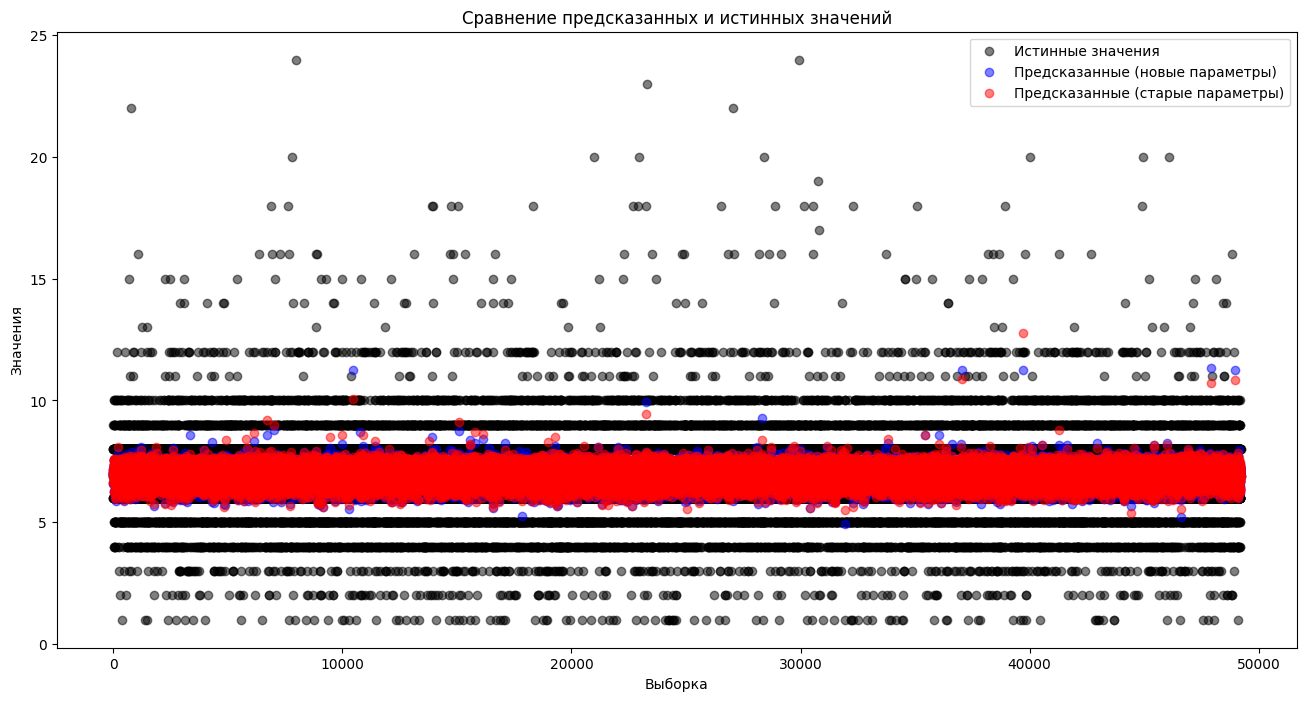

In [94]:
plt.figure(figsize=(16, 8))
plt.scatter(range(len(y_test)), y_test, label="Истинные значения", color="black", alpha=0.5)
plt.scatter(range(len(y_test)), y_new_pred, label="Предсказанные (новые параметры)", color="blue", alpha=0.5)
plt.scatter(range(len(y_test)), y_old_pred, label="Предсказанные (старые параметры)", color="red", alpha=0.5)
plt.xlabel("Выборка")
plt.ylabel("Значения")
plt.legend()
plt.title("Сравнение предсказанных и истинных значений")
plt.show()